In [244]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from matplotlib import pyplot as plt
%matplotlib inline 
xp = cuda.cupy
import time


def model_func(model):
    if xp == np:
        pass
    else :
        gpu_device = 0
        cuda.get_device(gpu_device).use()
        model.to_gpu(gpu_device)
xp.model_init = model_func
xp.pi = np.pi

In [281]:
def make_data(N = 10000, L = 100,sig = 0.01,bias = 0):
    p = xp.random.randn(N,L)
    s = xp.random.uniform(0,1,size=(N,1)) * 0
    ret = s + sig * p + bias
    return ret.astype(np.float32)
dat = make_data(10000,500)
dat2= make_data(10000,500,bias = 0.00)
print (dat)

[[ 0.01692302  0.00454811 -0.01318992 ..., -0.00027314 -0.00523405
   0.01007103]
 [ 0.01367094  0.00510387 -0.00687607 ..., -0.00966314 -0.00482958
  -0.0055878 ]
 [-0.01492564  0.00708597 -0.0071698  ...,  0.01838835  0.01456529
  -0.0056843 ]
 ..., 
 [ 0.00340152 -0.00124784  0.01274933 ..., -0.01138443 -0.00465462
   0.00481445]
 [-0.0331793  -0.01186314 -0.01117594 ...,  0.01107074  0.01582667
  -0.00608887]
 [-0.00321659  0.00130987  0.0089794  ..., -0.00618515  0.00939213
  -0.00317703]]


0.00990679


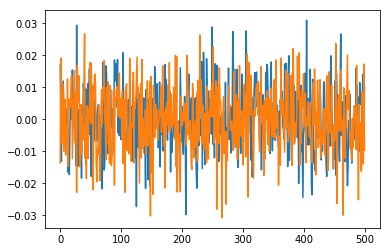

In [282]:
jj = 1
for i in range(jj):
    xx = cuda.to_cpu(dat[i])
    print (xp.std(xx))
    plt.plot(xx)

for i in range(jj):
    xx = cuda.to_cpu(dat2[i])
    #print (xp.std(xx))
    plt.plot(xx)
plt.show()

In [283]:
class Path:
    def __init__(this,val):
        this.v = val
        
    def __call__(this,func = None):
        if func == None :
            return this.v
        else:
            return Path(func(this.v))
    def __str__(this):
        return "$"+str(this.v)

def elu(x):
    return F.leaky_relu(x)

In [294]:
def catchW(dat):
    li = []
    if hasattr(dat,"W"):
        li.append(dat.W.data)
    if hasattr(dat,"lateral"):
        #li.append(dat.lateral.W.data)
        pass
    if hasattr(dat,"upward"):
        #li.append(dat.upward.W.data)
        pass
    return li   

def wreset(dat,sigma = 0.01):
    for w in catchW(dat):
        std = xp.std(w)
        w.data *= sigma / std
        print (xp.mean(xp.absolute(w)))
    
def wclip(dat,a = 0.01):
    for w in catchW(dat):
        w[w>a]=a
        w[w<-a]=-a

class Gen(Chain):
    def __init__(this):
        nz = 5
        super().__init__(
            p1 = L.Linear(nz,32),
            p2 = L.Linear(32,32),
            q1 = L.Linear(nz,32),
            q2 = L.Linear(32,32),
            r1 = L.Linear(32,32),
            r2 = L.Linear(32,1),
        )
    def reset_state(this):
        this.mem = None
        
    def first(this,x):
        this.mem = Path(x)(this.p1)(elu)(this.p2)()
        
    def __call__(this,x):
        h = Path( Path(x)(this.q1)(elu)(this.q2)() + this.mem )(elu)(this.r1)(elu)(this.r2)()
        return h
    

class Dis(Chain):
    def __init__(this):
        super().__init__(
            p1 = L.Linear(1,32),
            p2 = L.Linear(32,32),
            r1 = L.LSTM(32,32),
            q2 = L.Linear(32,32),
            q1 = L.Linear(32,1)
        )
        list(map(wreset,this.children()))
        
    def reset_state(this):
        this.r1.reset_state()
    
    def wclip(this):
        list(map(wclip,this.children()))
    
    def __call__(this,x):
        h = x
        h = Path(h)(this.p1)(elu)(this.p2)(elu)()
        #if this.h_r1 is not None:
        #    h += this.r1(this.h_r1)
        #this.h_r1 =h
        h = this.r1(h)
        h = Path(h)(this.q2)(elu)(this.q1)()
        y = h
        return y
    
lr = 0.000001
    
gen = Gen()
xp.model_init(gen)
o_gen = optimizers.RMSprop(lr)
o_gen.setup(gen)
o_gen.add_hook(chainer.optimizer.WeightDecay(0.0001))

dis = Dis()
xp.model_init(dis)
o_dis = optimizers.RMSprop(lr)
o_dis.setup(dis)
o_dis.add_hook(chainer.optimizer.WeightDecay(0.0001))

c = 0

0.00816848
0.0079782
0.00797821
0.00838325


/nfs/home/endo/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
stp = 1000
dep = 50
prt = 10
crt = 2

def getMini(dat,mini= 50):
    N = dat.shape[0]
    R = N//mini
    r = np.random.randint(R)
    return dat[r*mini:(r+1)*mini].reshape(mini,-1)

start = time.time()

for i in range(stp):
    c += 1
    
    for i in range(crt):
        L_dis = 0
        L_gen = 0
        
        #print ("-",end="")


        mini = getMini(dat)
        mini2= getMini(dat2)
        N = mini.shape[0]
        
        dis.reset_state()
        zF = xp.random.uniform(-1,1,size=(N,5)).astype(np.float32)
        gen.first(zF)
        yF = 0
        for i in range(dep):
            zF = xp.random.uniform(-1,1,size=(N,5)).astype(np.float32)
            xF = gen(zF)
            yF += dis(xF)
            
        
        dis.reset_state()
        yT = 0
        for i in range(dep):
            xT = mini[:,i:i+1]
            yT += dis(xT)
        
            
        L_dis = -F.sum(yT - yF)/N #maxmize y2-y1
        L_gen = -F.sum(yF)/N #maxmize y1


        dis.cleargrads()    
        L_dis.backward()
        o_dis.update()
        
        if i + 1 == crt and True:
            gen.cleargrads()
            L_gen.backward()
            o_gen.update()
            pass
        

        dis.wclip()
    
    if c % prt == 0:
        print (c,L_dis.data,time.time()-start)
    
    
    

10 -5.510990831680829e-06 11.459908246994019
20 -7.676530913158786e-06 22.854893445968628
30 -6.3898546613927465e-06 34.15721583366394
40 -8.435003110207617e-06 45.41435098648071
50 -1.0534804459894076e-05 57.04175114631653


In [ ]:
N = 5
M = 200

gen.reset_state()



yli = []

zF = xp.random.uniform(-1,1,size=(N,5)).astype(np.float32)
gen.first(zF)
for i in range(M):
    zF = xp.random.uniform(-1,1,size=(N,5)).astype(np.float32)
    y = gen(zF)
    yli.append(cuda.to_cpu(y.data))
yli = np.array(yli).reshape(-1,N).T
print (yli.shape)

plt.plot(yli.T)

print (np.std(yli,axis=1))
    
    